# Initial Data ETL and EDA

### 0.0 Import libraries and data

In [1]:
import warnings

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", DeprecationWarning)

In [2]:
# Loading
import json
# import pyspark
# from pyspark.sql import SparkSession

# Statistics
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, norm, skew, kurtosis

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Basic text processing
import html
import re
import string
import pickle
# import spacy
# from common import vocabulary

# NLTK processing
import nltk
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer

# Additional processing
import gensim
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser

from collections import Counter
from unicodedata import normalize
# from wordcloud import WordCloud

Data description: https://s3.amazonaws.com/amazon-reviews-pds/readme.html  
Data dictionary and download: https://s3.amazonaws.com/amazon-reviews-pds/tsv/index.txt

__Note:__ The potential advantage of this data is that usefulness can be calculated as a proportion rather than an absolute. Whereas the original data only provides the total # of votes for usefulness, this data provides the total votes for usefulness and the total overall votes.

__DATA COLUMNS:__  
__marketplace__       - 2 letter country code of the marketplace where the review was written.  
__customer_id__       - Random identifier that can be used to aggregate reviews written by a single author.  
__review_id__         - The unique ID of the review.  
__product_id__        - The unique Product ID the review pertains to. In the multilingual dataset the reviews for the same product in different countries can be grouped by the same product_id.  
__product_parent__    - Random identifier that can be used to aggregate reviews for the same product.  
__product_title__     - Title of the product.  
__product_category__  - Broad product category that can be used to group reviews (also used to group the dataset into coherent parts).  
__star_rating__       - The 1-5 star rating of the review.  
__helpful_votes__     - Number of helpful votes.  
__total_votes__       - Number of total votes the review received.  
__vine__              - Review was written as part of the Vine program.  
__verified_purchase__ - The review is on a verified purchase.  
__review_headline__   - The title of the review.  
__review_body__       - The review text.  
__review_date__       - The date the review was written.  

In [4]:
e_path = "../data/amazon_reviews_us_Electronics_v1_00.tsv"
f_path = "../data/amazon_reviews_us_Furniture_v1_00.tsv"
s_path = "../data/amazon_reviews_us_Sports_v1_00.tsv"

In [81]:
nrows = 10000

electronics = pd.read_csv(e_path,
                          sep='\t',
                          nrows=nrows,
                          on_bad_lines='skip'
                         )

furniture = pd.read_csv(f_path,
                        sep='\t',
                        nrows=nrows,
                        on_bad_lines='skip'
                       )

sports = pd.read_csv(s_path,
                     sep='\t',
                     nrows=nrows,
                     on_bad_lines='skip'
                    )


combined = pd.concat([electronics, furniture, sports])
combined.reset_index(drop=True, inplace=True)

### 1.0 Initial data investigation

In [82]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   marketplace        30000 non-null  object
 1   customer_id        30000 non-null  int64 
 2   review_id          30000 non-null  object
 3   product_id         30000 non-null  object
 4   product_parent     30000 non-null  int64 
 5   product_title      30000 non-null  object
 6   product_category   30000 non-null  object
 7   star_rating        30000 non-null  int64 
 8   helpful_votes      30000 non-null  int64 
 9   total_votes        30000 non-null  int64 
 10  vine               30000 non-null  object
 11  verified_purchase  30000 non-null  object
 12  review_headline    30000 non-null  object
 13  review_body        29991 non-null  object
 14  review_date        30000 non-null  object
dtypes: int64(5), object(10)
memory usage: 3.4+ MB


In [83]:
total_reviews = len(combined)
no_votes = len(combined[combined['total_votes'] == 0])
no_review = len(combined[combined['review_body'].isna()])

print("Of the {} reviews in the data, there are {} reviews with no votes and {} with no review text.".format(total_reviews,
                                                                                                             no_votes,
                                                                                                             no_review
                                                                                                            ))

Of the 30000 reviews in the data, there are 20938 reviews with no votes and 9 with no review text.


In [85]:
combined['verified_purchase'].value_counts()

Y    27975
N     2025
Name: verified_purchase, dtype: int64

### 2.0 Data processing and additional investigation

In [86]:
def data_processing(df, cols):

    '''
    df: set of review data to be processed
    cols: list of columns to keep in processed df
    
    Takes a dataframe and set of columns
    Filters out rows with no review body
    Classifies a review as helpful or not helpful based on having helpful votes greater than or less than
    80% of total votes.
    '''
    
    df = df[cols]
#     df = df[df['total_votes'] > 0]
    df = df[df['review_body'].notna()]

    df['helpful_ratio'] = df['helpful_votes'] / df['total_votes']
    df['helpful_ratio'] = df['helpful_ratio'].fillna(0)
    df['helpful'] = df['helpful_ratio'].apply(lambda x: 1 if x >= 0.8 else 0)
    return df    

In [87]:
cols = [
        'product_id',
        'product_parent',
        'product_category',
        'star_rating',
        'helpful_votes',
        'total_votes',
        'verified_purchase',
        'review_body'
       ]

processed_df = data_processing(combined, cols)

In [88]:
processed_df['helpful'].value_counts()

0    24294
1     5697
Name: helpful, dtype: int64

In [100]:
best_review = processed_df[processed_df['total_votes'] == processed_df['total_votes'].max()]
best_index = best_review.index.values[0]

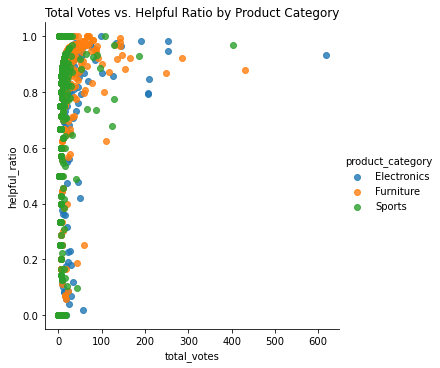

In [90]:
sns.lmplot(x='total_votes',
           y='helpful_ratio',
           hue='product_category',
           data=processed_df,
           fit_reg=False).set(title='')
plt.title('Total Votes vs. Helpful Ratio by Product Category')
plt.show()

In [91]:
def calculate_skew(df, groupby, cols):
    '''
    df: pandas dataframe
    groupby: column on which to group skew statistics
    cols: list of columns on which to calculate skew
    '''
    skews = []
    for col in cols:
        skews.append(list(df.groupby(groupby)[col].skew().values))
    
    skews = np.array(skews).T
    out_df = pd.DataFrame(data=skews,
                          index=df[groupby].unique(),
                          columns=cols
                         )
    return out_df

In [92]:
skew_cols = ['total_votes', 'helpful_votes', 'helpful_ratio']
groupby = 'product_category'

skew_df = calculate_skew(processed_df, groupby, skew_cols)
skew_df

,total_votes,helpful_votes,helpful_ratio
Electronics,39.264729,41.739289,1.792668
Furniture,21.570025,20.970827,0.871770
Sports,41.183413,46.261031,1.591591


### 3.0 Text processing

In [102]:
best_review

,product_id,product_parent,product_category,star_rating,helpful_votes,total_votes,verified_purchase,review_body,helpful_ratio,helpful
9267,B00NBEWB4U,920494172,Electronics,5,576,617,Y,**Quick Review***<br />Overall: 3 out of 5<br ...,0.933549,1


In [101]:
# Example review
print(processed_df["review_body"].iloc[best_index])

**Quick Review***<br />Overall: 3 out of 5<br />Sound Quality: 3.5 out of 5<br />Sound Trueness: 2 out of 5<br />Build Quality: 1 out of 5<br />Comfort: 2 out of 5<br />Noise Cancellation: 2 out of 5<br />Style & Appearance: 4 out of 5<br />Value: 5 out of 5<br />***The above are based on comparing these headphones to headphones priced as high as $350. I rated these headphones “5 Stars” on Amazon because they are easily a perfect score in every category when compared to products within a $50-$80 price range.***<br /><br />Full Review:<br />I purchased these headphones after seeing the insane amount of positive reviews over a $15 pair of headphones. My headphones of choice are the studio staple Sony MDR-7506. My pair is, however, wearing out quite a bit. And before investing another $100 on a new pair, I figured I’d give this set a try. Being someone who uses headphones for audio engineering and sound mastering, my preferences are typically geared towards a “clean” or “true” sound rathe

__Clean up text with basic standard procedures - will apply to baseline models and BERT__

In [103]:
def text_processing(df):
    '''
    Take in a dataframe and apply standard text cleaning
    '''
    
    # Remove special characters
    pattern = r"\&\#[0-9]+\;"

    df["review_body"] = df["review_body"].str.replace(pat=pattern, repl="", regex=True)

    # Replace linebreak symbol with space
    pattern = "<br />"
    df["review_body"] = df["review_body"].str.replace(pat=pattern, repl=" ", regex=True)

    # Remove extra spaces
    pattern = r"[\s]+"
    df["review_body"] = df["review_body"].str.replace(pat=pattern, repl=" ", regex=True)
    
    return df

In [105]:
clean_df = text_processing(processed_df)

# Example review
print(processed_df["review_body"].iloc[best_index])

**Quick Review*** Overall: 3 out of 5 Sound Quality: 3.5 out of 5 Sound Trueness: 2 out of 5 Build Quality: 1 out of 5 Comfort: 2 out of 5 Noise Cancellation: 2 out of 5 Style & Appearance: 4 out of 5 Value: 5 out of 5 ***The above are based on comparing these headphones to headphones priced as high as $350. I rated these headphones “5 Stars” on Amazon because they are easily a perfect score in every category when compared to products within a $50-$80 price range.*** Full Review: I purchased these headphones after seeing the insane amount of positive reviews over a $15 pair of headphones. My headphones of choice are the studio staple Sony MDR-7506. My pair is, however, wearing out quite a bit. And before investing another $100 on a new pair, I figured I’d give this set a try. Being someone who uses headphones for audio engineering and sound mastering, my preferences are typically geared towards a “clean” or “true” sound rather than a “good” sound. In other words, I’d rather my headphon

__Lemmatization - create a new field called 'review_procesed' to separate what will be used for baselines and BERT__

In [106]:
# Use lemmatization to reduce words to their root form

# import nltk resources
resources = ["wordnet", "stopwords", "punkt", \
             "averaged_perceptron_tagger", "maxent_treebank_pos_tagger"]

for resource in resources:
    try:
        nltk.data.find("tokenizers/" + resource)
    except LookupError:
        nltk.download(resource, quiet=True)

In [109]:
%%time
# create Lemmatizer object
lemma = WordNetLemmatizer()

def lemmatize_word(tagged_token):
    """ Returns lemmatized word given its tag"""
    root = []
    for token in tagged_token:
        tag = token[1][0]
        word = token[0]
        if tag.startswith('J'):
            root.append(lemma.lemmatize(word, wordnet.ADJ))
        elif tag.startswith('V'):
            root.append(lemma.lemmatize(word, wordnet.VERB))
        elif tag.startswith('N'):
            root.append(lemma.lemmatize(word, wordnet.NOUN))
        elif tag.startswith('R'):
            root.append(lemma.lemmatize(word, wordnet.ADV))
        else:          
            root.append(word)
    return root

def lemmatize_doc(document):
    """ Tags words then returns sentence with lemmatized words"""
    lemmatized_list = []
    tokenized_sent = sent_tokenize(document)
    for sentence in tokenized_sent:
        no_punctuation = re.sub(r"[`'\",.!?()]", " ", sentence)
        tokenized_word = word_tokenize(no_punctuation)
        tagged_token = pos_tag(tokenized_word)
        lemmatized = lemmatize_word(tagged_token)
        lemmatized_list.extend(lemmatized)
    return " ".join(lemmatized_list)

# apply functions to review text
clean_df["review_processed"] = clean_df["review_body"].apply(lambda row: lemmatize_doc(row))

CPU times: user 60 s, sys: 1.33 s, total: 1min 1s
Wall time: 1min 1s


In [110]:
# Example review
print(clean_df["review_processed"].iloc[best_index])
print("")

* * Quick Review * * * Overall : 3 out of 5 Sound Quality : 3 5 out of 5 Sound Trueness : 2 out of 5 Build Quality : 1 out of 5 Comfort : 2 out of 5 Noise Cancellation : 2 out of 5 Style & Appearance : 4 out of 5 Value : 5 out of 5 * * * The above be base on compare these headphone to headphone price as high as $ 350 I rat these headphone “ 5 Stars ” on Amazon because they be easily a perfect score in every category when compare to product within a $ 50- $ 80 price range * * * Full Review : I purchase these headphone after see the insane amount of positive review over a $ 15 pair of headphone My headphone of choice be the studio staple Sony MDR-7506 My pair be however wear out quite a bit And before invest another $ 100 on a new pair I figure I ’ d give this set a try Being someone who use headphone for audio engineering and sound master my preference be typically gear towards a “ clean ” or “ true ” sound rather than a “ good ” sound In other word I ’ d rather my headphone leave bad r

__Non-standard text processing decisions - again for baselines, but not BERT__

In [111]:
def text_processing_two(df):

    # Remove accents
    remove_accent = lambda text: normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")
    df["review_processed"] = df["review_processed"].apply(remove_accent)

    # Remove punctuation
    pattern = r"[^\w\s]"
    df["review_processed"] = df["review_processed"].str.replace(pat=pattern, repl=" ", regex=True)

    # Convert to lowercase
    df["review_processed"] = df["review_processed"].str.lower()

    # Remove stopwords
    stop_words = stopwords.words("english")
    stop_words = [word.replace("\'", "") for word in stop_words]

    remove_stop_words = lambda row: " ".join([token for token in row.split(" ") if token not in stop_words])
    df["review_processed"] = df["review_processed"].apply(remove_stop_words)
    
    return df

clean_df = text_processing_two(clean_df)

In [112]:
# Example review
print(clean_df["review_processed"].iloc[best_index])
print("")

    quick review       overall   3 5 sound quality   3 5 5 sound trueness   2 5 build quality   1 5 comfort   2 5 noise cancellation   2 5 style   appearance   4 5 value   5 5       base compare headphone headphone price high   350 rat headphone  5 stars  amazon easily perfect score every category compare product within   50    80 price range       full review   purchase headphone see insane amount positive review   15 pair headphone headphone choice studio staple sony mdr 7506 pair however wear quite bit invest another   100 new pair figure  give set try someone use headphone audio engineering sound master preference typically gear towards  clean   true  sound rather  good  sound word  rather headphone leave bad record quality sound bad rather make poor record sound great rat headphone sound  quality   trueness  separate category grade headphone comparison headphone price range rating reflection compare headphone comparable model similar price sound quality   3 5 casual listen get muc

### 4.0 Output data for modeling

In [113]:
clean_df.to_csv('../data/combined.csv')